### Finding Heavy Traffic Indicators on I-94

### The I-94 Traffic Dataset

We're going to analyze a dataset about the westbound traffic on the I-94 Interstate highway. John Hogue made the dataset available, and you can download it from the UCI Machine Learning Repository.

The goal of our analysis is to determine a few indicators of heavy traffic on I-94. These indicators can be weather type, time of the day, time of the week, etc. For instance, we may find out that the traffic is usually heavier in the summer or when it snows.

We'll start by exploring the .CSV file:

In [1]:
import pandas as pd

i_94 = pd.read_csv('CSV FILES/Metro_Interstate_Traffic_Volume.csv')
i_94.head()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918


In [2]:
i_94.tail()

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450
48203,None,282.12,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 23:00:00,954


In [3]:
i_94.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48204 entries, 0 to 48203
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   holiday              48204 non-null  object 
 1   temp                 48204 non-null  float64
 2   rain_1h              48204 non-null  float64
 3   snow_1h              48204 non-null  float64
 4   clouds_all           48204 non-null  int64  
 5   weather_main         48204 non-null  object 
 6   weather_description  48204 non-null  object 
 7   date_time            48204 non-null  object 
 8   traffic_volume       48204 non-null  int64  
dtypes: float64(3), int64(2), object(4)
memory usage: 3.3+ MB


The dataset has 48,204 rows and 9 columns, and there are no null values. Each row describes traffic and weather data for a specific hour — we have data from 2012-10-02 09:00:00 until 2018-09-30 23:00:00.

A station located approximately midway between Minneapolis and Saint Paul records the traffic data (see the dataset documentation). For this station, the direction of the route is westbound (i.e., cars moving from east to west). This means that the results of our analysis will be about the westbound traffic in the proximity of the station. In other words, we should avoid generalizing our results for the entire I-94 highway.



### Analyzing Traffic Volume¶

We're going to start our analysis by examining the distribution of the 'traffic_volume' column.

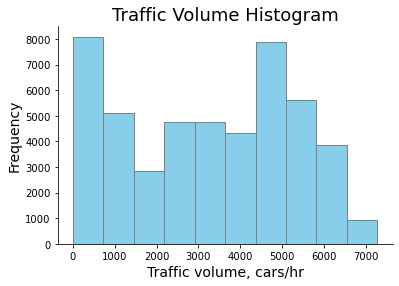

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

i_94['traffic_volume'].plot.hist(color='skyblue', edgecolor='gray')
plt.title('Traffic Volume Histogram', fontsize=18)
plt.xlabel('Traffic volume, cars/hr', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
sns.despine()

In [5]:
i_94['traffic_volume'].describe()

count    48204.000000
mean      3259.818355
std       1986.860670
min          0.000000
25%       1193.000000
50%       3380.000000
75%       4933.000000
max       7280.000000
Name: traffic_volume, dtype: float64

Between 2012-10-02 09:00:00 and 2018-09-30 23:00:00, the hourly traffic volume varied from 0 to 7,280 cars, with an average of 3,260 cars.

About 25% of the time, there were only 1,193 cars or fewer passing the station each hour — this probably occurs during the night, or when a road is under construction. However, about 25% of the time, the traffic volume was four times as much (4,933 cars or more).

This observation gives our analysis an interesting direction: comparing daytime data with nighttime data.



Traffic Volume: Day vs. Night
We'll start by dividing the dataset into two parts:

- Daytime data: hours from 7 AM to 7 PM (12 hours).
- Night-time data: hours from 7 PM to 7 AM (12 hours).
While this is not a perfect criterion for distinguishing between nighttime and daytime, it's a good starting point.

In [6]:
i_94['date_time'] = pd.to_datetime(i_94['date_time'])

day = i_94.copy()[(i_94['date_time'].dt.hour >= 7) & (i_94['date_time'].dt.hour < 19)]
print(day.shape)

night = i_94.copy()[(i_94['date_time'].dt.hour >= 19) | (i_94['date_time'].dt.hour < 7)]
print(night.shape)

(23877, 9)
(24327, 9)


This significant difference in row numbers between day and night is due to a few hours of missing data. For instance, if you look at rows 176 and 177 (i_94.iloc[176:178]), you'll notice there's no data for two hours (4 and 5).

In [7]:
i_94.iloc[176:178]

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
176,None,281.17,0.0,0.0,90,Clouds,overcast clouds,2012-10-10 03:00:00,361
177,None,281.25,0.0,0.0,92,Clear,sky is clear,2012-10-10 06:00:00,5875


### Traffic Volume: Day vs. Night (II)

Now that we've isolated day and night, we're going to look at the histograms of traffic volume side-by-side by using a grid chart.

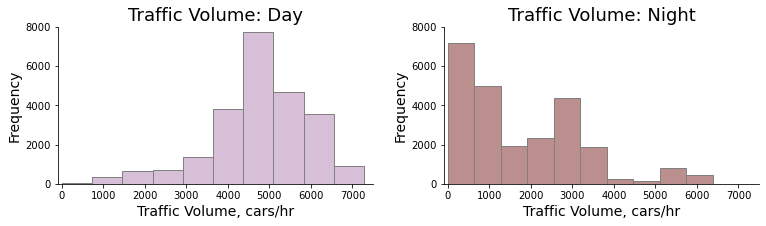

In [50]:
plt.figure(figsize=(11, 3.5))

plt.subplot(1, 2, 1)
plt.hist(day['traffic_volume'], color='thistle', edgecolor='gray')
plt.xlim([-100, 7500])
plt.ylim([0, 8000])
plt.title('Traffic Volume: Day', fontsize=18)
plt.xlabel('Traffic Volume, cars/hr', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
sns.despine()

plt.subplot(1, 2, 2)
plt.hist(night['traffic_volume'], color='rosybrown', edgecolor='gray')
plt.xlim([-100, 7500])
plt.ylim([0, 8000])
plt.title('Traffic Volume: Night', fontsize=18)
plt.xlabel('Traffic Volume, cars/hr', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
sns.despine()

plt.tight_layout(pad=2)

In [9]:
day['traffic_volume'].describe()

count    23877.000000
mean      4762.047452
std       1174.546482
min          0.000000
25%       4252.000000
50%       4820.000000
75%       5559.000000
max       7280.000000
Name: traffic_volume, dtype: float64

In [10]:
night['traffic_volume'].describe()

count    24327.000000
mean      1785.377441
std       1441.951197
min          0.000000
25%        530.000000
50%       1287.000000
75%       2819.000000
max       6386.000000
Name: traffic_volume, dtype: float64

The histogram that shows the distribution of traffic volume during the day is left skewed. This means that most of the traffic volume values are high — there are 4,252 or more cars passing the station each hour 75% of the time (because 25% of values are less than 4,252).

The histogram displaying the nighttime data is right skewed. This means that most of the traffic volume values are low — 75% of the time, the number of cars that passed the station each hour was less than 2,819.

Although there are still measurements of over 5,000 cars per hour, the traffic at night is generally light. Our goal is to find indicators of heavy traffic, so we'll only focus on the daytime data moving forward.

Time Indicators
One of the possible indicators of heavy traffic is time. There might be more people on the road in a certain month, on a certain day, or at a certain time of day.

We're going to look at a few line plots showing how the traffic volume changes according to the following:

- Month.
- Day of the week.
- Time of day.

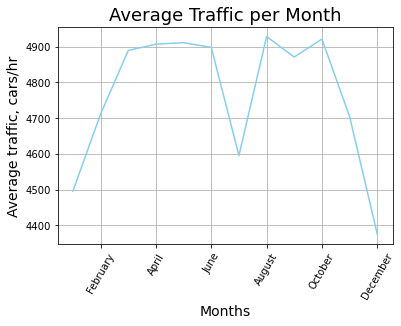

In [57]:
day['month'] = day['date_time'].dt.month
by_month = day.groupby('month').mean()
by_month['traffic_volume'].plot.line(color='skyblue')
plt.title('Average Traffic per Month', fontsize=18)
plt.xticks([2, 4, 6, 8, 10, 12], ['February', 'April', 'June', 'August', 'October', 'December'], rotation=60)
plt.xlabel('Months', fontsize=14)
plt.ylabel('Average traffic, cars/hr', fontsize=14)
plt.grid()
plt.show()

The traffic looks less heavy during cold months (November–February) and more intense during warm months (March–October), with one interesting exception: July. Is there anything special about July? Is traffic significantly less heavy in July each year?

To answer the last question, let's see how the traffic volume changed each year in July.

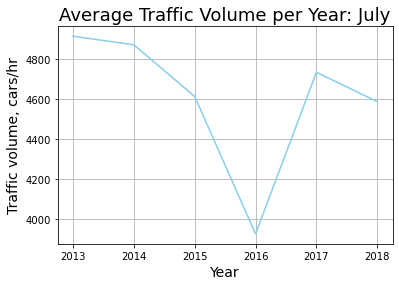

In [58]:
day['year'] = day['date_time'].dt.year
only_july = day[day['month'] == 7]
only_july.groupby('year').mean()['traffic_volume'].plot.line(color='skyblue')
plt.title('Average Traffic Volume per Year: July', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Traffic volume, cars/hr', fontsize=14)
plt.grid()
plt.show()

Typically, the traffic is pretty heavy in July, similar to the other warm months. The only exception we see is 2016, which had a high decrease in traffic volume. One possible reason for this is road construction — [this article from 2016](https://www.crainsdetroit.com/article/20160728/NEWS/160729841/weekend-construction-i-96-us-23-bridge-work-i-94-lane-closures-i-696) supports this hypothesis.

As a tentative conclusion here, we can say that warm months generally show heavier traffic compared to cold months. In a warm month, you can expect for each hour of daytime a traffic volume close to 5,000 cars.

### Time Indicators (II)

Let's now look at a more granular indicator: day number.

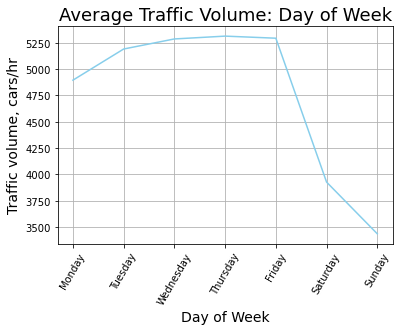

In [59]:
day['dayofweek'] = day['date_time'].dt.dayofweek
by_dayofweek = day.groupby('dayofweek').mean()
by_dayofweek['traffic_volume'].plot.line(color='skyblue')
plt.title('Average Traffic Volume: Day of Week', fontsize=18)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=60)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Traffic volume, cars/hr', fontsize=14)
plt.grid()
plt.show()

Traffic volume is significantly heavier on business days (Monday – Friday). Except for Monday, we only see values over 5,000 during business days. Traffic is lighter on weekends, with values below 4,000 cars.

### Time indicators (III)

Let's now see what values we have based on time of the day. The weekends, however, will drag down the average values, so we're going to look only at the averages separately.

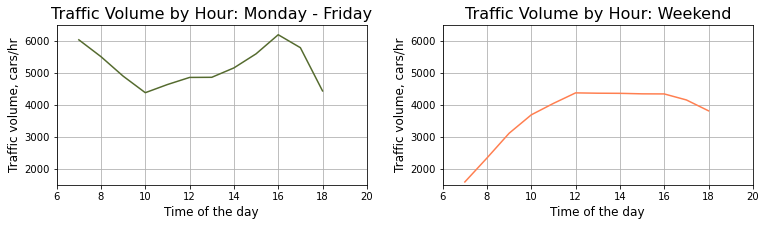

In [47]:
day['hour'] = day['date_time'].dt.hour
business_days = day.copy()[day['dayofweek'] <= 4] # 4 == Friday
weekend = day.copy()[day['dayofweek'] >= 5] # 5 == Saturday
by_hour_business = business_days.groupby('hour').mean()
by_hour_weekend = weekend.groupby('hour').mean()

plt.figure(figsize=(11, 3.5))

plt.subplot(1, 2, 1)
by_hour_business['traffic_volume'].plot.line(color='darkolivegreen')
plt.xlim([6, 20])
plt.ylim([1500, 6500])
plt.xlabel('Time of the day', fontsize=12)
plt.ylabel('Traffic volume, cars/hr', fontsize=12)
plt.title('Traffic Volume by Hour: Monday - Friday', fontsize=16)
plt.grid()

plt.subplot(1, 2, 2)
by_hour_weekend['traffic_volume'].plot.line(color='coral')
plt.xlim([6, 20])
plt.ylim([1500, 6500])
plt.xlabel('Time of the day', fontsize=12)
plt.ylabel('Traffic volume, cars/hr', fontsize=12)
plt.title('Traffic Volume by Hour: Weekend', fontsize=16)
plt.grid()

plt.tight_layout(pad=2)
plt.show()

At each hour of the day, the traffic volume is generally higher during business days compared to the weekends. As somehow expected, the rush hours are around 7 and 16 — when most people travel from home to work and back. We see volumes of over 6,000 cars at rush hours.

To summarize, we found a few time-related indicators of heavy traffic:

- The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
- The traffic is usually heavier on business days compared to weekends.
- On business days, the rush hours are around 7 and 16.


### Weather Indicators

Another possible indicator of heavy traffic is weather. The dataset provides us with a few useful columns about weather: 'temp', 'rain_1h', 'snow_1h', 'clouds_all', 'weather_main', 'weather_description'.

A few of these columns are numerical, so let's start by looking up their correlation values with 'traffic_volume'.

In [15]:
day.corr()['traffic_volume']

temp              0.128317
rain_1h           0.003697
snow_1h           0.001265
clouds_all       -0.032932
traffic_volume    1.000000
month            -0.022337
year             -0.003557
dayofweek        -0.416453
hour              0.172704
Name: traffic_volume, dtype: float64

Temperature shows the strongest correlation with a value of just +0.13. The other relevant columns (rain_1h, snow_1h, clouds_all) don't show any strong correlation with 'traffic_value'.

Let's generate a scatter plot to visualize the correlation between temp and traffic_volume.

day.plot.scatter('temp', 'traffic_volume', color='#1e90ff', alpha=0.1)
plt.title('Traffic Volume at Different Temperatures', fontsize=18)
plt.xlabel('Temperature, K', fontsize=14)
plt.ylabel('Traffic volume, cars/hr', fontsize=14)
sns.despine()

We observe two wrong temperature values ​​that must be ignored to better appreciate the scatter plot.

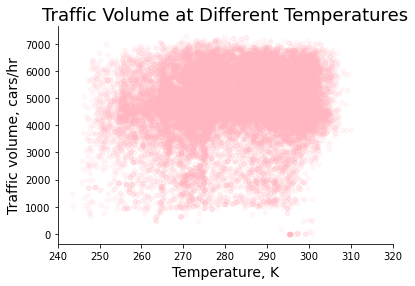

In [42]:
day.plot.scatter('temp', 'traffic_volume', color='lightpink', alpha=0.1)
plt.xlim([240, 320]) # two wrong 0K temperatures mess up the x-axis.
plt.title('Traffic Volume at Different Temperatures', fontsize=18)
plt.xlabel('Temperature, K', fontsize=14)
plt.ylabel('Traffic volume, cars/hr', fontsize=14)
sns.despine()

We can conclude that temperature doesn't look like a solid indicator of heavy traffic.

Let's now look at the other weather-related columns: 'weather_main' and 'weather_description'.

### Weather Types

To start, we're going to group the data by 'weather_main' and look at the 'traffic_volume' averages.

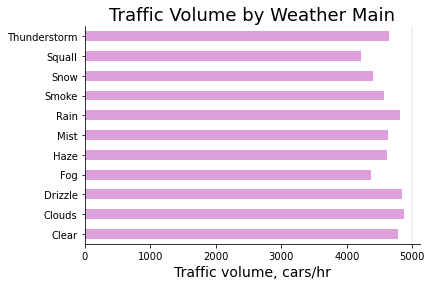

In [43]:
by_weather_main = day.groupby('weather_main').mean()
by_weather_main['traffic_volume'].plot.barh(color='plum')
plt.xlabel('Traffic volume, cars/hr', fontsize=14)
plt.ylabel('')
plt.title('Traffic Volume by Weather Main', fontsize=18)
plt.axvline(x=5000, color='#6c7b8b', linewidth=0.2)
sns.despine()

It looks like there's no weather type where traffic volume exceeds 5,000 cars. This makes finding a heavy traffic indicator more difficult. Let's also group by 'weather_description', which has a more granular weather classification.

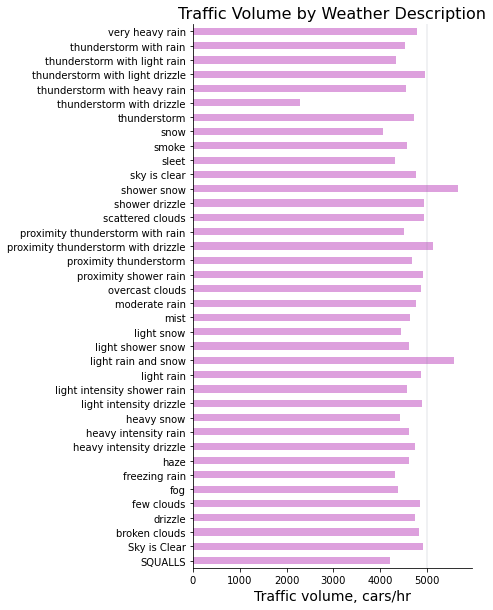

In [44]:
by_weather_description = day.groupby('weather_description').mean()
by_weather_description['traffic_volume'].plot.barh(figsize=(5, 10), color='plum')
plt.xlabel('Traffic volume, cars/hr', fontsize=14)
plt.ylabel('')
plt.title('Traffic Volume by Weather Description', fontsize=16)
plt.axvline(x=5000, color='#6c7b8b', linewidth=0.2)
sns.despine()

It looks like there are three weather types where traffic volume exceeds 5,000:

- Shower snow.
- Light rain and snow.
- Proximity thunderstorm with drizzle.

It is not clear why these types of weather have the highest average traffic values; this is bad weather, but not so bad. However, we must bear in mind that really bad weather conditions are generally forecast in advance, so perhaps people try to anticipate to avoid traveling on those days.

### Next Steps: Traffic analysis at night-time

We previously concluded that daytime traffic was much more intense than nighttime traffic. Recall that our goal was to find indicators of heavy traffic, so we only considered daytime traffic data. Now that we have the main influencing factors, our further task will be to analyze the nighttime traffic data taking into account different hourly and meteorological indicators.

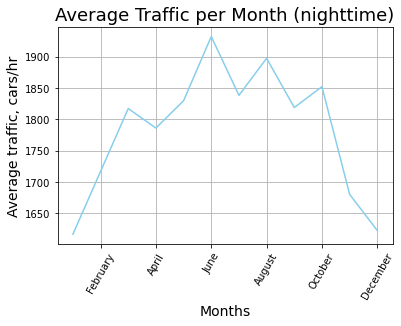

In [60]:
night['month'] = night['date_time'].dt.month
night_by_month = night.groupby('month').mean()
night_by_month['traffic_volume'].plot.line(color='skyblue')
plt.title('Average Traffic per Month (nighttime)', fontsize=18)
plt.xticks([2, 4, 6, 8, 10, 12], ['February', 'April', 'June', 'August', 'October', 'December'], rotation=60)
plt.xlabel('Months', fontsize=14)
plt.ylabel('Average traffic, cars/hr', fontsize=14)
plt.grid()
plt.show()

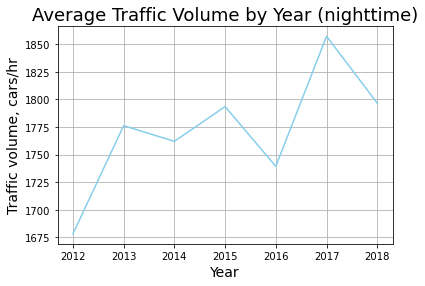

In [61]:
night['year'] = night['date_time'].dt.year
night.groupby('year').mean()['traffic_volume'].plot.line(color='skyblue')
plt.title('Average Traffic Volume by Year (nighttime)', fontsize=18)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Traffic volume, cars/hr', fontsize=14)
plt.grid()
plt.show()

In the monthly night traffic graph, we observe that the months of June and August were registered the highest values. We must bear in mind that those are warm months. However, a decrease is observed in the month of July. One possible reason for this is road construction, as mentioned earlier during the daytime traffic analysis.

In the annual graph, we note that 2017 records the highest traffic value. This is most likely due to the adjustment of the [speed limit on I-94 west of Minneapolis](https://www.mprnews.org/story/2017/06/06/i94-construction-zone-speed-limit-reduced) due to construction work on the road.

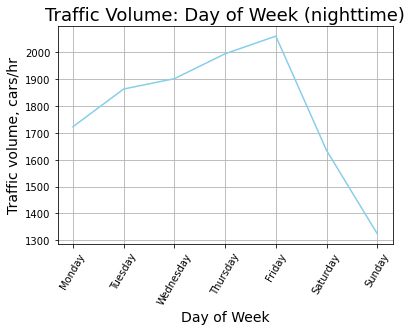

In [62]:
night['dayofweek'] = night['date_time'].dt.dayofweek
by_dayofweek_night = night.groupby('dayofweek').mean()
by_dayofweek_night['traffic_volume'].plot.line(color='skyblue')
plt.title('Traffic Volume: Day of Week (nighttime)', fontsize=18)
plt.xticks([0, 1, 2, 3, 4, 5, 6], ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=60)
plt.xlabel('Day of Week', fontsize=14)
plt.ylabel('Traffic volume, cars/hr', fontsize=14)
plt.grid()
plt.show()

In contrast to daytime records, nighttime traffic is considerably less intense on weekends.

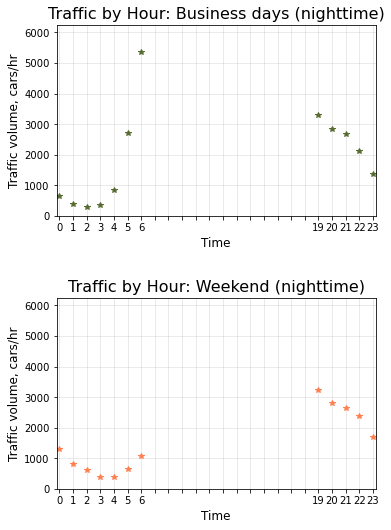

In [34]:
night['hour'] = night['date_time'].dt.hour
business_days_night = night.copy()[night['dayofweek'] <= 4] # 4 == Friday
weekend_night = night.copy()[night['dayofweek'] >= 5] # 5 == Saturday
by_hour_business_night = business_days_night.groupby('hour').mean()
by_hour_weekend_night = weekend_night.groupby('hour').mean()

labels = ['0','1', '2', '3', '4', '5', '6', '', '', '', '', '', '', '', '', '', '', '', '', '19', '20','21','22','23']
ticks=[i for i in range(24)]
plt.figure(figsize=(6, 8))

plt.subplot(2, 1, 1)
by_hour_business_night['traffic_volume'].plot.line(color='darkolivegreen', linestyle=' ', marker='*')
plt.xlim([-0.2, 23.2])
plt.ylim([0, 6250])
plt.xticks(ticks=ticks, labels=labels)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Traffic volume, cars/hr', fontsize=12)
plt.title('Traffic by Hour: Business days (nighttime)', fontsize=16)
plt.grid(color='gray', alpha=0.2)

plt.subplot(2, 1, 2)
by_hour_weekend_night['traffic_volume'].plot.line(color='coral', linestyle=' ', marker='*')
plt.xlim([-0.2, 23.2])
plt.ylim([0, 6250])
plt.xticks(ticks=ticks, labels=labels)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Traffic volume, cars/hr', fontsize=12)
plt.title('Traffic by Hour: Weekend (nighttime)', fontsize=16)
plt.grid(color='gray', alpha=0.2)

plt.tight_layout(pad=3)
plt.show()

In the business days plot, we see that traffic gradually decreases from 7:00 p.m. till 2:00 a.m., and then increases rapidly from 3:00 a.m. till 6:00 p.m. While in the weekend graph, we see that traffic it reaches its minimum at 3.00. Then, from 4:00 till 6:00 it increases again, but slightly.

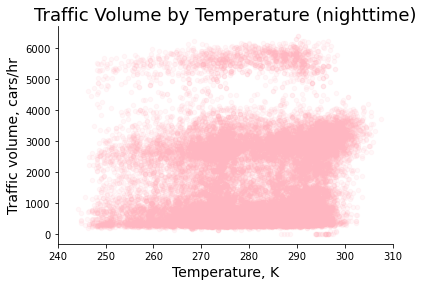

In [35]:
night.plot.scatter('temp', 'traffic_volume', color='lightpink', alpha=0.1)
plt.xlim([240, 310])
plt.title('Traffic Volume by Temperature (nighttime)', fontsize=18)
plt.xlabel('Temperature, K', fontsize=14)
plt.ylabel('Traffic volume, cars/hr', fontsize=14)
sns.despine()

In [24]:
print(night.corr()['traffic_volume'][['temp', 'rain_1h', 'snow_1h', 'clouds_all']])


temp          0.094004
rain_1h      -0.012972
snow_1h      -0.007453
clouds_all    0.012832
Name: traffic_volume, dtype: float64


We noted that temperature does not influence nighttime traffic intensity, despite having relatively strongest Pearson correlation coefficient.

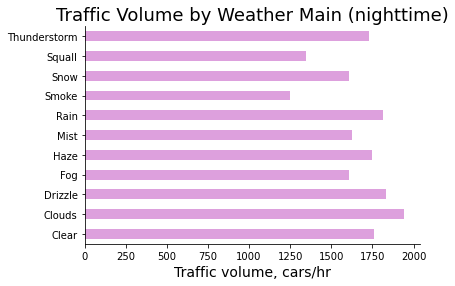

In [40]:
by_weather_main_night = night.groupby('weather_main').mean()
by_weather_main_night['traffic_volume'].plot.barh(color='plum')
plt.xlabel('Traffic volume, cars/hr', fontsize=14)
plt.ylabel('')
plt.title('Traffic Volume by Weather Main (nighttime)', fontsize=18)
sns.despine()

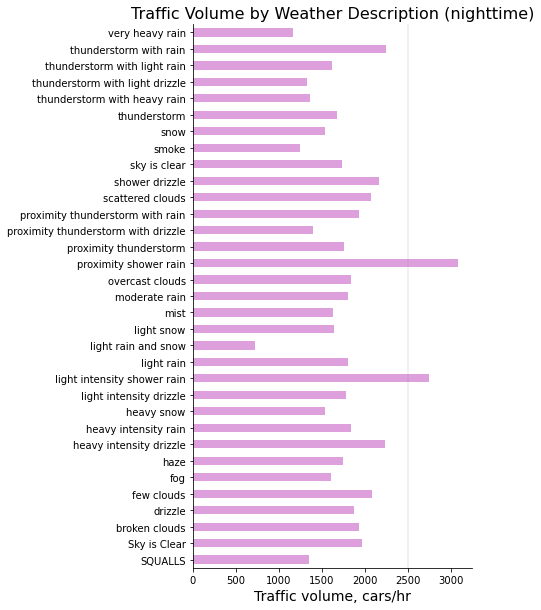

In [41]:
by_weather_description_night = night.groupby('weather_description').mean()
by_weather_description_night['traffic_volume'].plot.barh(figsize=(5, 10), color='plum')
plt.xlabel('Traffic volume, cars/hr', fontsize=14)
plt.ylabel('')
plt.title('Traffic Volume by Weather Description (nighttime)', fontsize=16)
plt.axvline(x=2500, color='#6c7b8b', linewidth=0.2)
sns.despine()

It's noted that some weather types may contribute slightly to relatively heavier nighttime traffic (>2'500 cars/hr):

- Proximity shower rain.
- Light intensity shower rain.
These weather types aren't that bad, but they probably aren't forecast as far in advance as severe weather, so they can't stop people from driving at night.

### Conclusion
In this project, we tried to find a few indicators of heavy traffic on the I-94 Interstate highway. We managed to find two types of indicators:

***Time indicators***

- The traffic is usually heavier during warm months (March–October) compared to cold months (November–February).
- The traffic is usually heavier on business days compared to the weekends.
- On business days, the rush hours are around 7 and 16.

***Weather indicators***

**Daytime:**

- Shower snow.
- Light rain and snow.
- Proximity thunderstorm with drizzle.

**Nighttime:**

- Proximity shower rain.
- Light intensity shower rain.